In [7]:
# Importing necessary libraries
import pandas as pd
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import numpy as np

# Load datasets
qualitative_data = pd.read_csv('~/Downloads/rmpCapstoneQual.csv')
tags_data = pd.read_csv('~/Downloads/rmpCapstoneTags.csv')
numerical_data = pd.read_csv('~/Downloads/rmpCapstoneNum.csv')

# Data Cleaning and Preprocessing
# Drop rows with missing values across all datasets to align them
aligned_indices = numerical_data.dropna().index.intersection(tags_data.index).intersection(qualitative_data.dropna().index)

numerical_data_aligned = numerical_data.loc[aligned_indices].reset_index(drop=True)
tags_data_aligned = tags_data.loc[aligned_indices].reset_index(drop=True)
qualitative_data_aligned = qualitative_data.loc[aligned_indices].reset_index(drop=True)

# Normalize tag counts by the number of ratings per professor
normalized_tags = tags_data_aligned.div(numerical_data_aligned.iloc[:, 2], axis=0).fillna(0)

# Ensure alignment across datasets
assert numerical_data_aligned.shape[0] == tags_data_aligned.shape[0] == qualitative_data_aligned.shape[0]


Most Gendered Tags: [('0.11', 8.897615118242492e-93), ('0.15', 1.6661997109135138e-26), ('0.14', 1.3875883031678273e-23)]
Least Gendered Tags: [('1', 0.002346499472215538), ('0.3', 0.00502538252342778), ('0.7', 0.7055502303341206)]


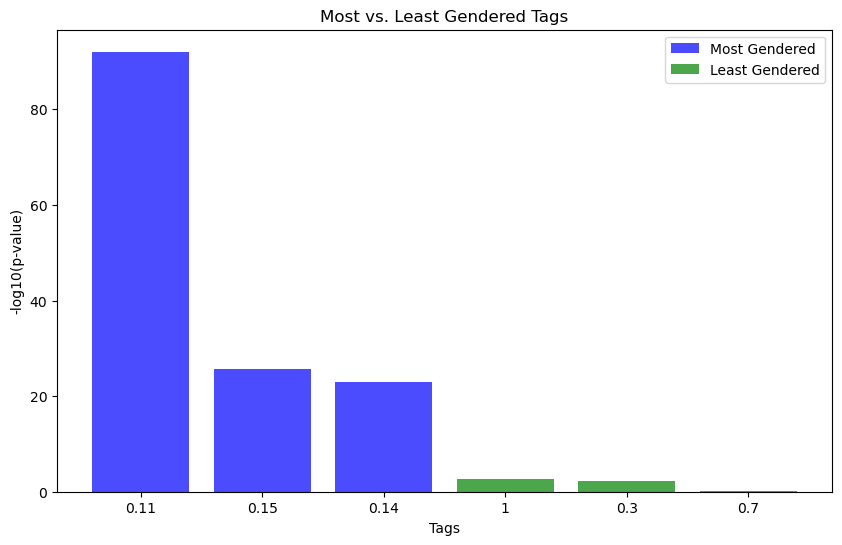

In [8]:
# Question 4: Gender Differences in Tags
# Separate male and female data
male_tags = normalized_tags[numerical_data_aligned.iloc[:, 6] == 1]
female_tags = normalized_tags[numerical_data_aligned.iloc[:, 7] == 1]

# Perform t-tests for each tag
p_values_tags = []
for tag in normalized_tags.columns:
    _, p_value = ttest_ind(male_tags[tag], female_tags[tag], equal_var=False)
    p_values_tags.append(p_value)

# Identify the most and least gendered tags
most_gendered_tags = np.argsort(p_values_tags)[:3]
least_gendered_tags = np.argsort(p_values_tags)[-3:]

# Print results for Question 4
print("Most Gendered Tags:", [(normalized_tags.columns[i], p_values_tags[i]) for i in most_gendered_tags])
print("Least Gendered Tags:", [(normalized_tags.columns[i], p_values_tags[i]) for i in least_gendered_tags])

# Plot for most vs least gendered tags
plt.figure(figsize=(10, 6))
most_gendered_tags_plot = [normalized_tags.columns[i] for i in most_gendered_tags]
least_gendered_tags_plot = [normalized_tags.columns[i] for i in least_gendered_tags]
most_gendered_pvalues = [-np.log10(p_values_tags[i]) for i in most_gendered_tags]
least_gendered_pvalues = [-np.log10(p_values_tags[i]) for i in least_gendered_tags]

plt.bar(most_gendered_tags_plot, most_gendered_pvalues, label='Most Gendered', color='blue', alpha=0.7)
plt.bar(least_gendered_tags_plot, least_gendered_pvalues, label='Least Gendered', color='green', alpha=0.7)
plt.xlabel('Tags')
plt.ylabel('-log10(p-value)')
plt.title('Most vs. Least Gendered Tags')
plt.legend()
plt.show()

Question 8: Predicting Average Ratings (Revised)
R2 (Ridge): 0.7313870111439797
RMSE (Ridge): 0.43346512968884227
Top Predictive Features (Ridge):
0.14    1.148505
0.1     0.970756
0.2     0.948743
0.10    0.933178
0.15    0.822554
dtype: float64


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


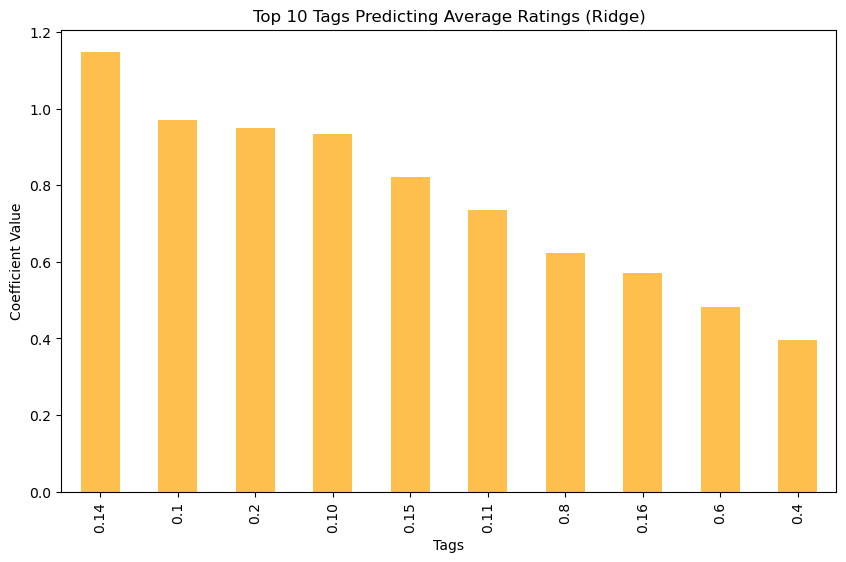

In [9]:
# Question 8: Predicting Average Ratings

# Function to calculate VIF
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Calculate VIF for normalized tags
vif_data = calculate_vif(normalized_tags)

# Remove features with high VIF (e.g., VIF > 10)
high_vif_features = vif_data[vif_data["VIF"] > 10]["Feature"]
reduced_X_tags = normalized_tags.drop(columns=high_vif_features, axis=1)

X_tags = reduced_X_tags
y_ratings = numerical_data_aligned.iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X_tags, y_ratings, test_size=0.2, random_state=42)

# Using Ridge regression to handle collinearity
ridge_rating_model = RidgeCV(alphas=[0.1, 1.0, 10.0])
ridge_rating_model.fit(X_train, y_train)
y_pred_ridge_ratings = ridge_rating_model.predict(X_test)

r2_ridge_ratings = r2_score(y_test, y_pred_ridge_ratings)
rmse_ridge_ratings = mean_squared_error(y_test, y_pred_ridge_ratings, squared=False)
ridge_coefficients_ratings = pd.Series(ridge_rating_model.coef_, index=X_tags.columns).sort_values(ascending=False)

print("Question 8: Predicting Average Ratings (Revised)")
print("R2 (Ridge):", r2_ridge_ratings)
print("RMSE (Ridge):", rmse_ridge_ratings)
print("Top Predictive Features (Ridge):")
print(ridge_coefficients_ratings.head())

# Plot revised top predictors for average ratings
plt.figure(figsize=(10, 6))
ridge_coefficients_ratings[:10].plot(kind='bar', color='orange', alpha=0.7)
plt.xlabel('Tags')
plt.ylabel('Coefficient Value')
plt.title('Top 10 Tags Predicting Average Ratings (Ridge)')
plt.show()


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Question 9: Predicting Average Difficulty (Revised)
R2 (Ridge): 0.5572049858006065
RMSE (Ridge): 0.5008281528293256
Top Predictive Features (Ridge):
0       1.667591
0.12    1.271092
0.8     0.819472
0.5     0.519196
1       0.483315
dtype: float64


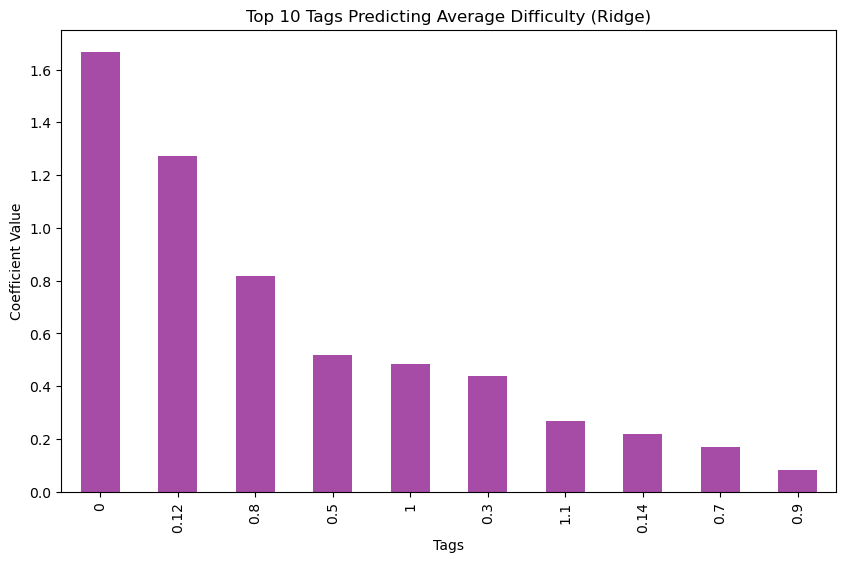

In [10]:
# Question 9: Predicting Average Difficulty
y_difficulty = numerical_data_aligned.iloc[:, 1]

X_train_difficulty, X_test_difficulty, y_train_difficulty, y_test_difficulty = train_test_split(
    X_tags, y_difficulty, test_size=0.2, random_state=42
)

# Using Ridge regression for difficulty prediction
ridge_difficulty_model = RidgeCV(alphas=[0.1, 1.0, 10.0])
ridge_difficulty_model.fit(X_train_difficulty, y_train_difficulty)
y_pred_ridge_difficulty = ridge_difficulty_model.predict(X_test_difficulty)

r2_ridge_difficulty = r2_score(y_test_difficulty, y_pred_ridge_difficulty)
rmse_ridge_difficulty = mean_squared_error(y_test_difficulty, y_pred_ridge_difficulty, squared=False)
ridge_coefficients_difficulty = pd.Series(ridge_difficulty_model.coef_, index=X_tags.columns).sort_values(ascending=False)

# Print results for Question 9
print("Question 9: Predicting Average Difficulty (Revised)")
print("R2 (Ridge):", r2_ridge_difficulty)
print("RMSE (Ridge):", rmse_ridge_difficulty)
print("Top Predictive Features (Ridge):")
print(ridge_coefficients_difficulty.head())

# Plot revised top predictors for average difficulty
plt.figure(figsize=(10, 6))
ridge_coefficients_difficulty[:10].plot(kind='bar', color='purple', alpha=0.7)
plt.xlabel('Tags')
plt.ylabel('Coefficient Value')
plt.title('Top 10 Tags Predicting Average Difficulty (Ridge)')
plt.show()
